In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from featexp import get_univariate_plots, get_trend_stats
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Loading Datasets

In [2]:
def read_model_dataset(chosen, combine_cats = False):
    non_features = ['u_id', 'p_id']
    demo_cols = []
    predictor = ['pur']
    file_name = ""

    if chosen == 0:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    elif chosen == 1:
        file_name = "some_one_hot.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'occ_0', 'occ_1', 'occ_10',
               'occ_11', 'occ_12', 'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17',
               'occ_18', 'occ_19', 'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5',
               'occ_6', 'occ_7', 'occ_8', 'occ_9', 'city_A', 'city_B', 'city_C']
    elif chosen == 2:
        file_name = "all_one_hot.csv"
        demo_cols = ['gender', 'married', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
               'age_5', 'age_6', 'occ_0', 'occ_1', 'occ_10', 'occ_11', 'occ_12',
               'occ_13', 'occ_14', 'occ_15', 'occ_16', 'occ_17', 'occ_18', 'occ_19',
               'occ_2', 'occ_20', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_7', 'occ_8',
               'occ_9', 'city_0', 'city_1', 'city_2',
               'years_in_city_0', 'years_in_city_1', 'years_in_city_2',
               'years_in_city_3', 'years_in_city_4']
    elif chosen == 3:
        file_name = "BlackFriday.csv"
        non_features = ['User_ID', 'Product_ID']
        demo_cols = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
        predictor = ['Purchase']
    else:
        file_name = "minimal_preprocess.csv"
        demo_cols = ['gender', 'age', 'years_in_city', 'married', 'city', 'occ']
    
    if combine_cats and chosen != 0 or chosen != 3:
        modeldf = pd.read_csv("inputs/p_combined_" + file_name)
    else:
        modeldf = pd.read_csv("inputs/" + file_name)
    # modeldf = modeldf.drop(non_features, axis = 1)
    # line below removes purchase outliers from modeldf
    # modeldf = modeldf[modeldf["pur"] < modeldf["pur"].quantile(0.99)]
    
    X = modeldf.drop(predictor, axis = 1).drop(non_features, axis = 1)
    y = modeldf[predictor]
    
    return modeldf, X, y, predictor, demo_cols

In [3]:
# minimal_preprocess = 0
# some_one_hot = 1
# all_one_hot = 2
# raw_df = 3
# defaults to minimal_preprocess

modeldf, X, y, predictor, demo_cols = read_model_dataset(1, combine_cats = False)
modeldf.head()

,age,city_A,city_B,city_C,gender,married,occ_0,occ_1,occ_10,occ_11,...,p_cat_4,p_cat_5,p_cat_6,p_cat_7,p_cat_8,p_cat_9,p_id,pur,u_id,years_in_city
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,69042,8370,1,2
1,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,248942,15200,1,2
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,87842,1422,1,2
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,85442,1057,1,2
4,6,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,285442,7969,2,4


In [4]:
raw_df , _, _, raw_predictor, raw_demo_cols = read_model_dataset(3, combine_cats = False)
raw_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# Analysis/Exploration

In [27]:
modeldf.describe()

,u_id,p_id,gender,age,occ,city,years_in_city,married,p_cat_1,p_cat_2,p_cat_3,pur
count,537577.000000,537577.000000,537577.000000,537577.000000,537577.00000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000,537577.000000
mean,2991.847028,173319.290509,0.754087,2.494755,8.08271,1.040567,1.859458,0.408797,5.295546,6.784907,3.871773,9333.859853
std,1714.392695,101715.607539,0.430627,1.352583,6.52412,0.759627,1.289828,0.491612,3.750701,6.211618,6.265963,4981.022133
min,1.000000,142.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,185.000000
25%,1495.000000,96742.000000,1.000000,2.000000,2.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,5866.000000
50%,3031.000000,165842.000000,1.000000,2.000000,7.00000,1.000000,2.000000,0.000000,5.000000,5.000000,0.000000,8062.000000
75%,4417.000000,256742.000000,1.000000,3.000000,14.00000,2.000000,3.000000,1.000000,8.000000,14.000000,8.000000,12073.000000
max,6040.000000,370642.000000,1.000000,6.000000,20.00000,2.000000,4.000000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [31]:
print("Unique values for each column\n---------------\n")

for col in modeldf.columns:
    print("%s: %d" % (col, modeldf[col].nunique()))

Unique values for each column
---------------

u_id: 5891
p_id: 3623
gender: 2
age: 7
occ: 21
city: 3
years_in_city: 5
married: 2
p_cat_1: 18
p_cat_2: 18
p_cat_3: 16
pur: 17959


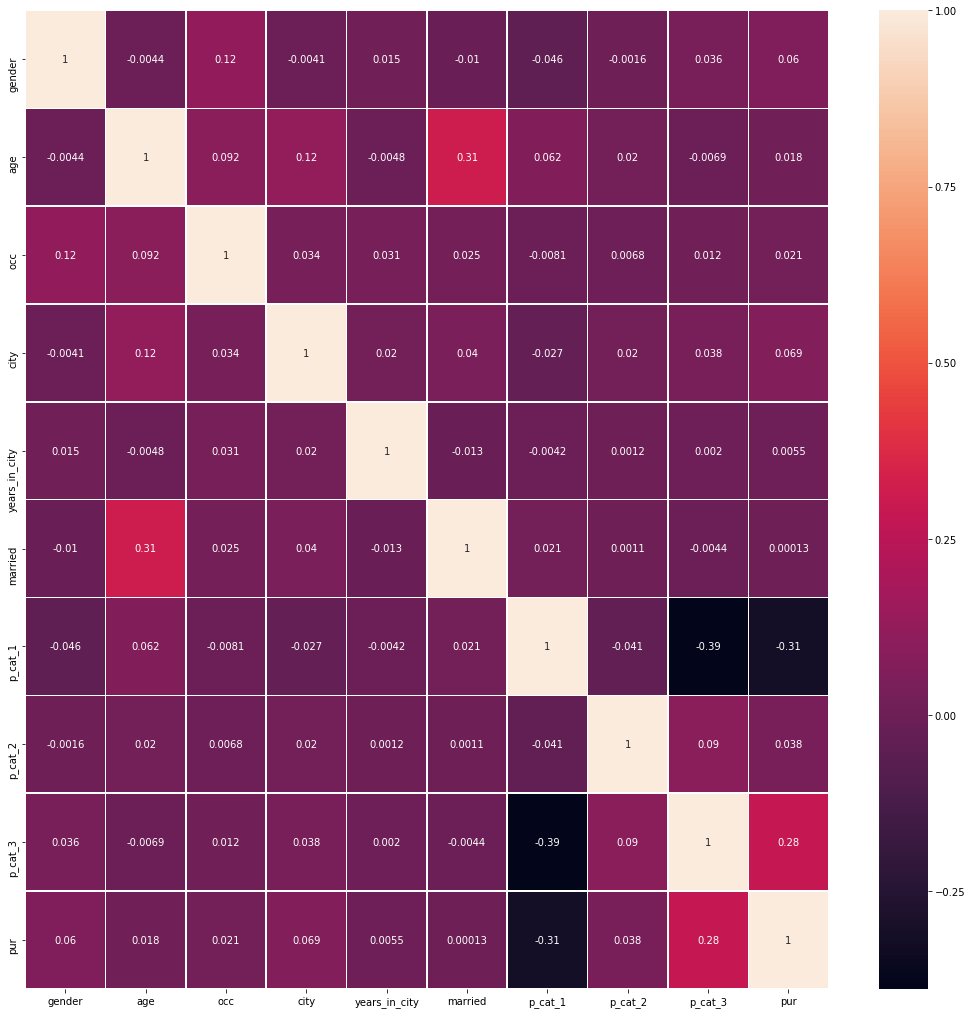

In [5]:
fig, axes = plt.subplots(figsize=(18, 18))
sns.heatmap(modeldf.corr(), annot = True, linewidths=.5)

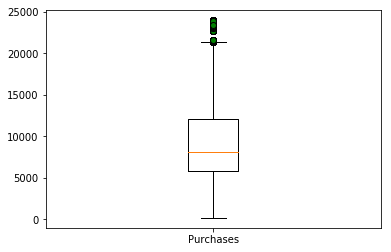

In [13]:
props = dict(marker='.', markerfacecolor='green', markersize=12, linestyle='none')
plt.boxplot(modeldf['pur'], flierprops = props)
plt.xticks([1], ['Purchases'])
plt.show()

## Overview

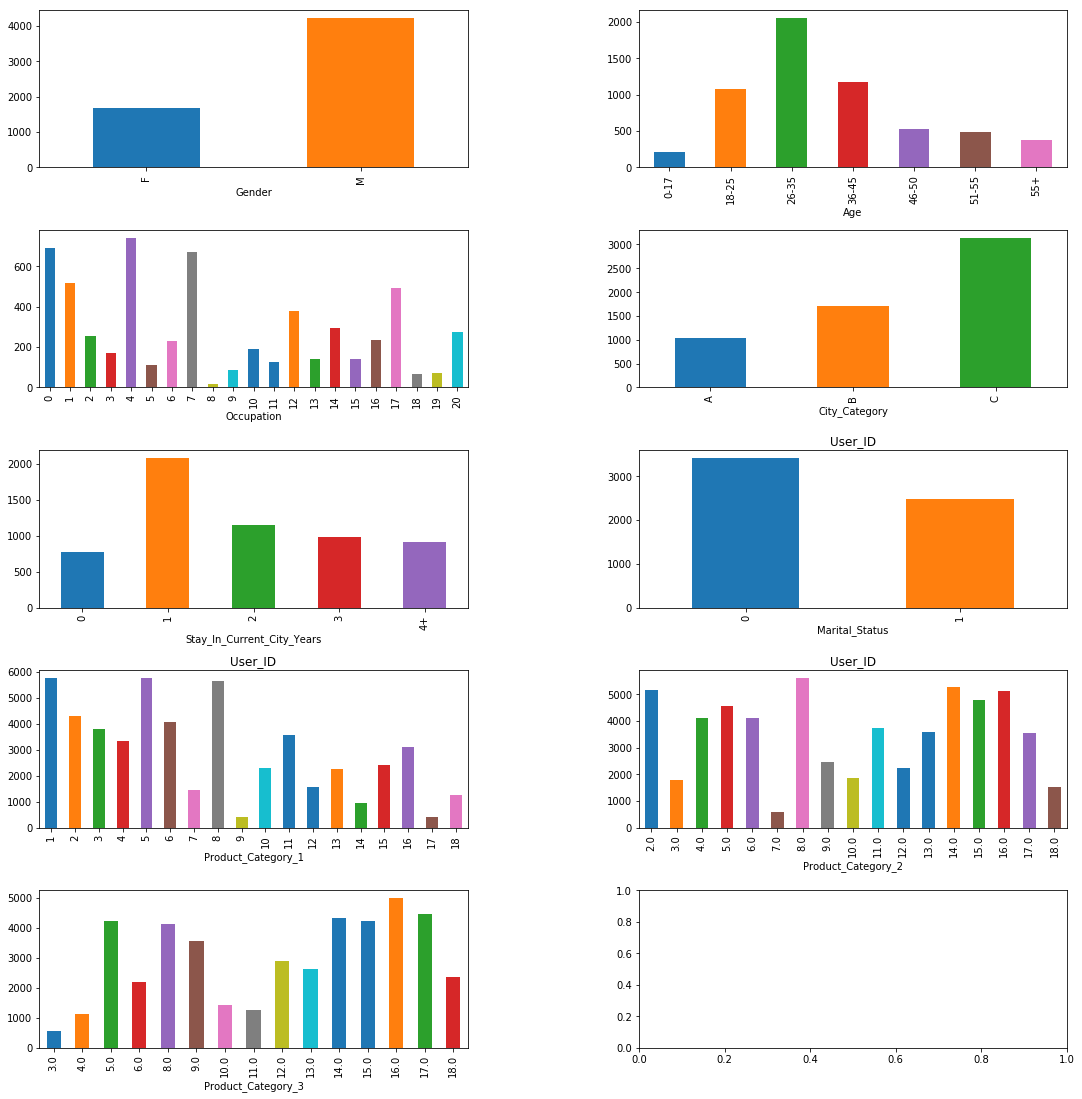

In [53]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(wspace=0.4,hspace=0.4)

raw_df['User_ID'].groupby(raw_df['Gender']).nunique().plot(kind='bar',ax=axes[0,0])
raw_df['User_ID'].groupby(raw_df['Age']).nunique().plot(kind='bar',ax=axes[0,1])
raw_df['User_ID'].groupby(raw_df['Occupation']).nunique().plot(kind='bar',ax=axes[1,0])
raw_df['User_ID'].groupby(raw_df['City_Category']).nunique().plot(kind='bar',ax=axes[1,1])
raw_df['User_ID'].groupby(raw_df['Stay_In_Current_City_Years']).nunique().plot(kind='bar',ax=axes[2,0])
raw_df['User_ID'].groupby(raw_df['Marital_Status']).nunique().plot(subplots=True,kind='bar',ax=axes[2,1])
raw_df['User_ID'].groupby(raw_df['Product_Category_1']).nunique().plot(subplots=True,kind='bar',ax=axes[3,0])
raw_df['User_ID'].groupby(raw_df['Product_Category_2']).nunique().plot(subplots=True,kind='bar',ax=axes[3,1])
raw_df['User_ID'].groupby(raw_df['Product_Category_3']).nunique().plot(kind='bar',ax=axes[4,0])

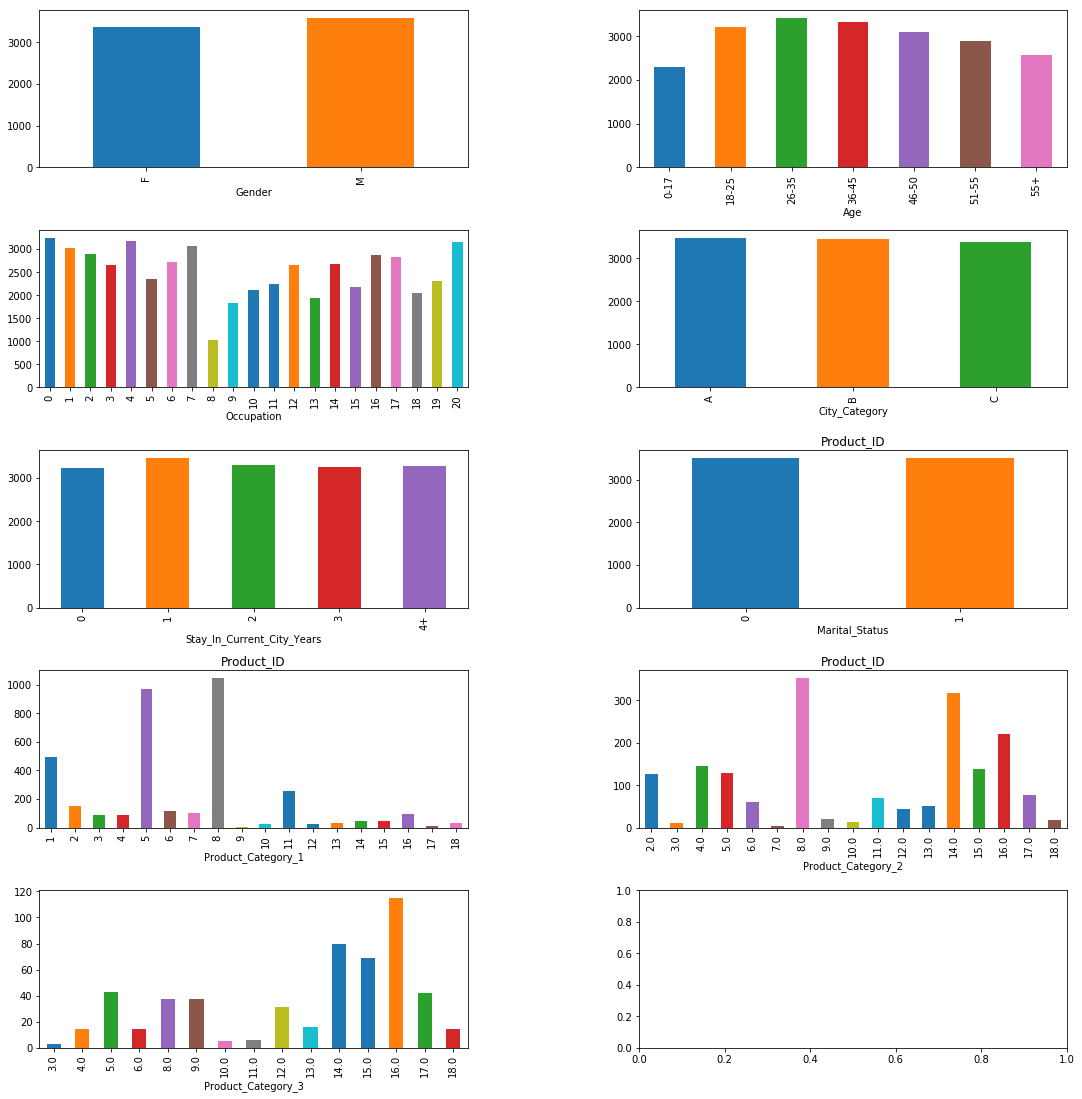

In [54]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(wspace=0.4,hspace=0.4)

raw_df['Product_ID'].groupby(raw_df['Gender']).nunique().plot(kind='bar',ax=axes[0,0])
raw_df['Product_ID'].groupby(raw_df['Age']).nunique().plot(kind='bar',ax=axes[0,1])
raw_df['Product_ID'].groupby(raw_df['Occupation']).nunique().plot(kind='bar',ax=axes[1,0])
raw_df['Product_ID'].groupby(raw_df['City_Category']).nunique().plot(kind='bar',ax=axes[1,1])
raw_df['Product_ID'].groupby(raw_df['Stay_In_Current_City_Years']).nunique().plot(kind='bar',ax=axes[2,0])
raw_df['Product_ID'].groupby(raw_df['Marital_Status']).nunique().plot(subplots=True,kind='bar',ax=axes[2,1])
raw_df['Product_ID'].groupby(raw_df['Product_Category_1']).nunique().plot(subplots=True,kind='bar',ax=axes[3,0])
raw_df['Product_ID'].groupby(raw_df['Product_Category_2']).nunique().plot(subplots=True,kind='bar',ax=axes[3,1])
raw_df['Product_ID'].groupby(raw_df['Product_Category_3']).nunique().plot(kind='bar',ax=axes[4,0])

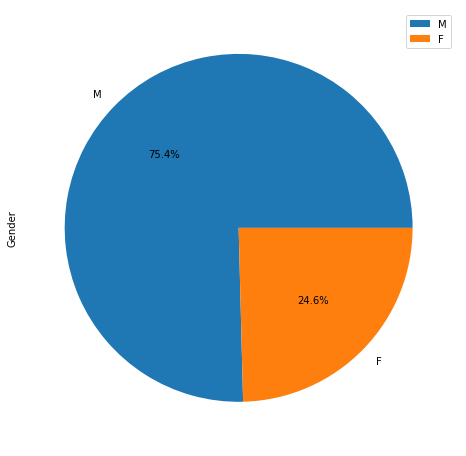

In [143]:
plot = raw_df['Gender'].value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%')
plot.legend()

## Demographics

In [153]:
def plot(group, column, plot):
    ax=plt.figure(figsize=(12,6))
    plt.ylabel(column)
    raw_df.groupby(group)[column].sum().plot(plot)
    
def plot_pie(column):
    plot = raw_df[column].value_counts().plot.pie(figsize=(8, 8), autopct='%1.1f%%')
    plot.legend()

### Gender

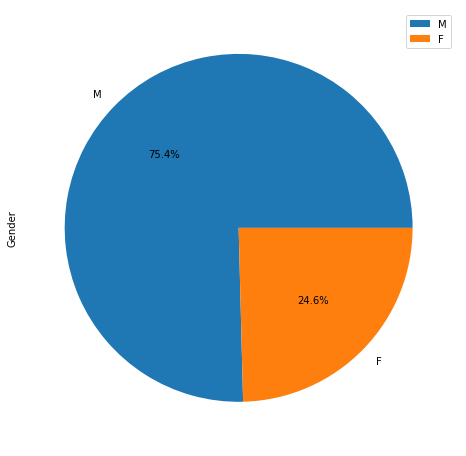

In [145]:
plot_pie('Gender')

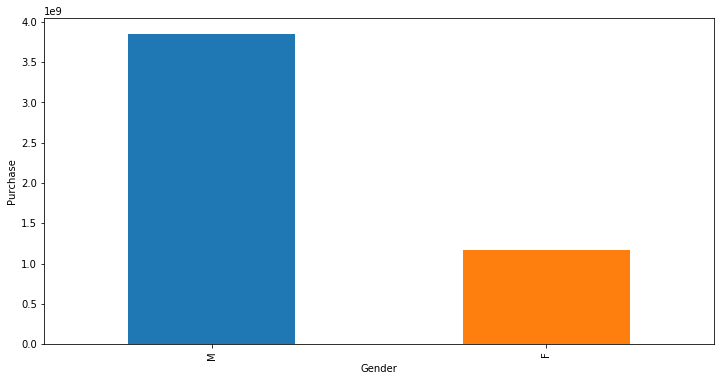

In [82]:
plot('Gender','Purchase','bar')

### Age

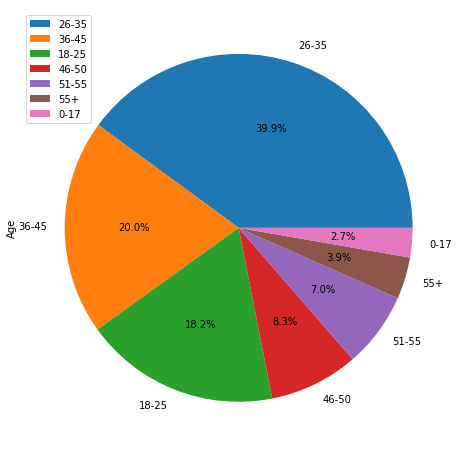

In [146]:
plot_pie('Age')

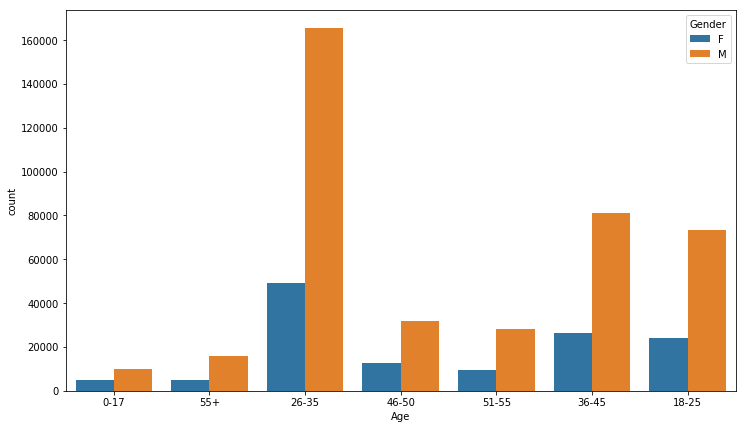

In [85]:
fig1, ax1 = plt.subplots(figsize=(12,7))
sns.countplot(raw_df['Age'],hue=raw_df['Gender'])

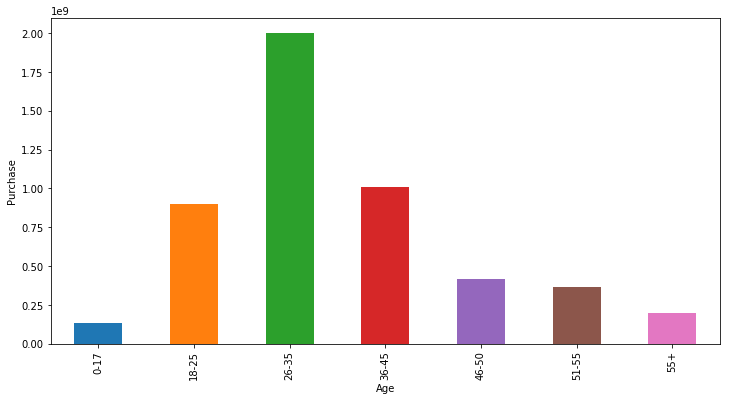

In [155]:
plot('Age','Purchase','bar')

### Occupation

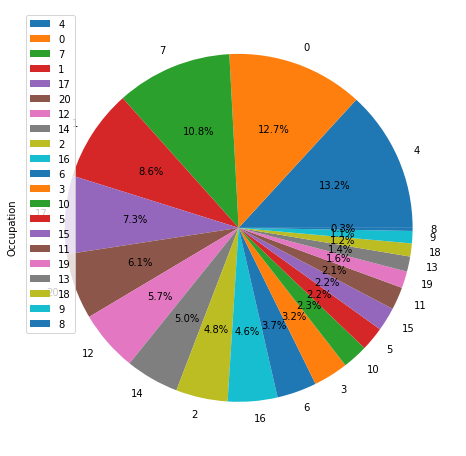

In [147]:
plot_pie('Occupation')

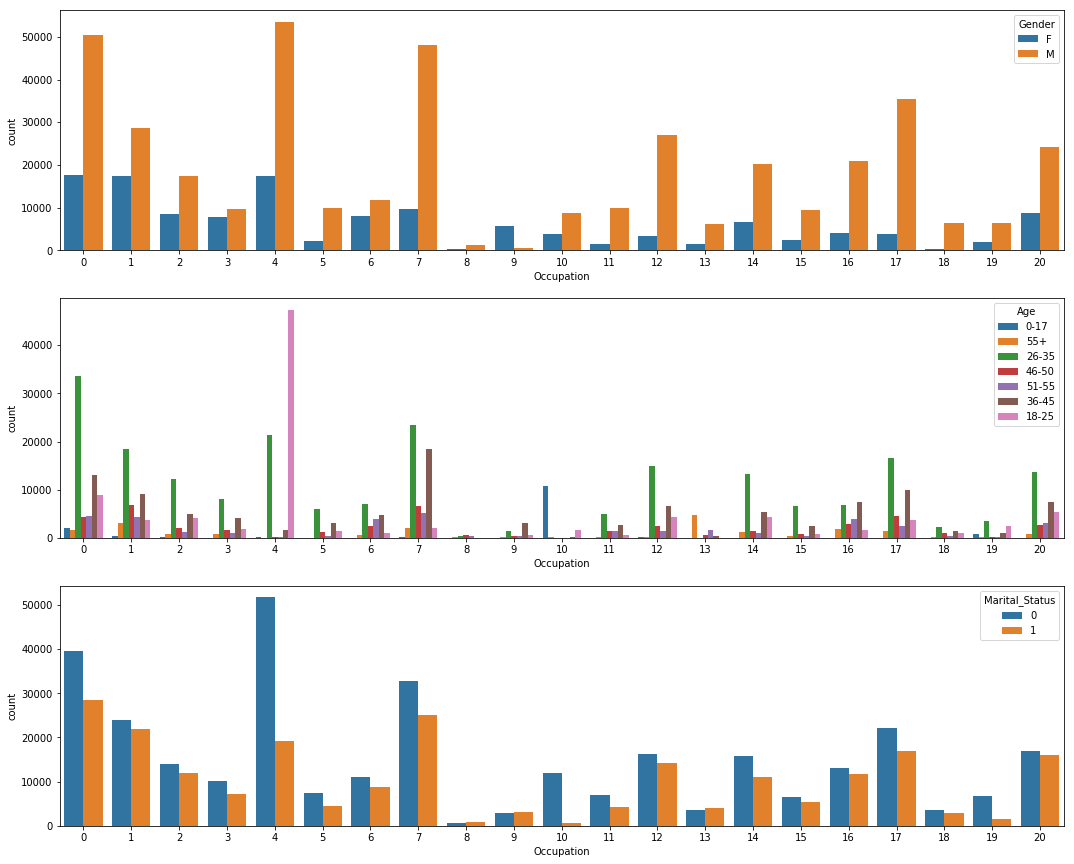

In [185]:
fig1, ax1 = plt.subplots(3, 1, figsize=(18,15))
sns.countplot(raw_df['Occupation'],hue=raw_df['Gender'], ax = ax1[0])
sns.countplot(raw_df['Occupation'],hue=raw_df['Age'], ax = ax1[1])
sns.countplot(raw_df['Occupation'],hue=raw_df['Marital_Status'], ax = ax1[2])

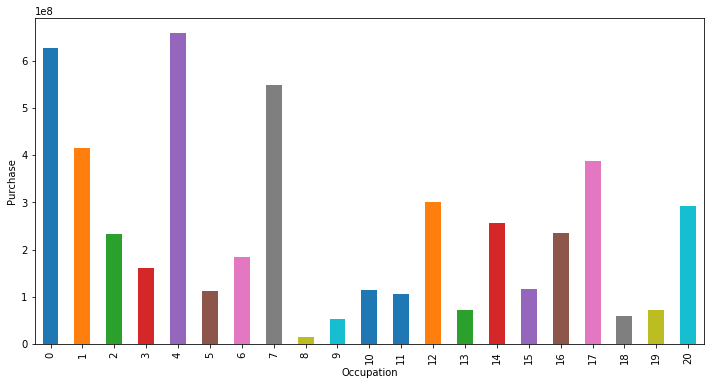

In [154]:
plot('Occupation','Purchase','bar')

### City

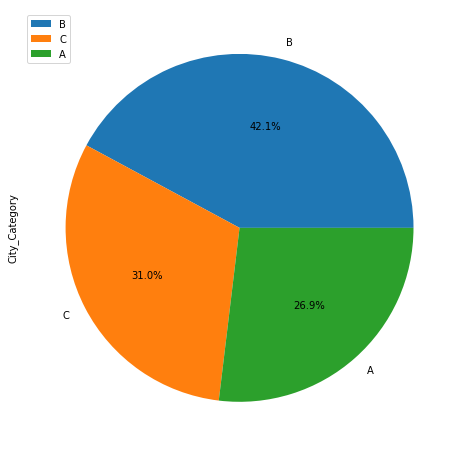

In [148]:
plot_pie('City_Category')

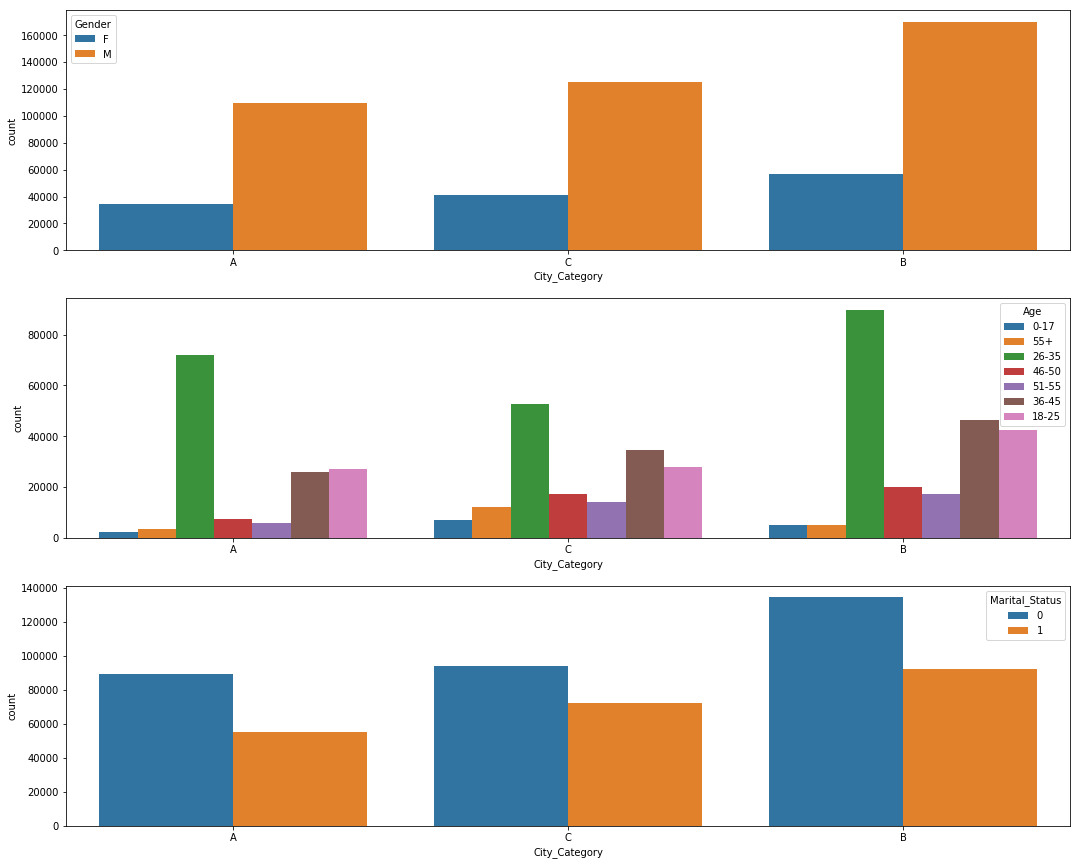

In [188]:
fig1, ax1 = plt.subplots(3, 1, figsize=(18,15))
sns.countplot(raw_df['City_Category'],hue=raw_df['Gender'], ax = ax1[0])
sns.countplot(raw_df['City_Category'],hue=raw_df['Age'], ax = ax1[1])
sns.countplot(raw_df['City_Category'],hue=raw_df['Marital_Status'], ax = ax1[2])

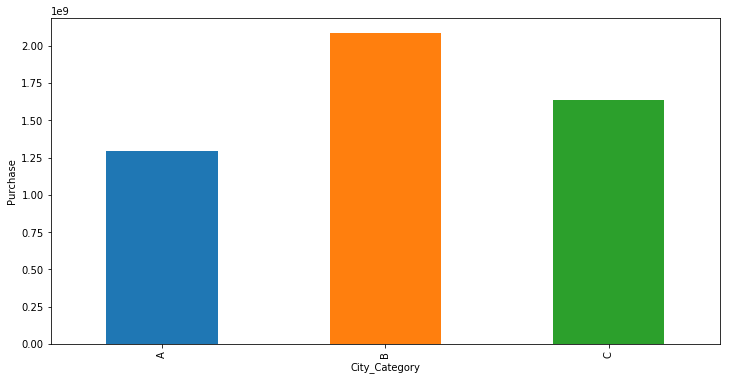

In [165]:
plot('City_Category','Purchase','bar')

### Years in City

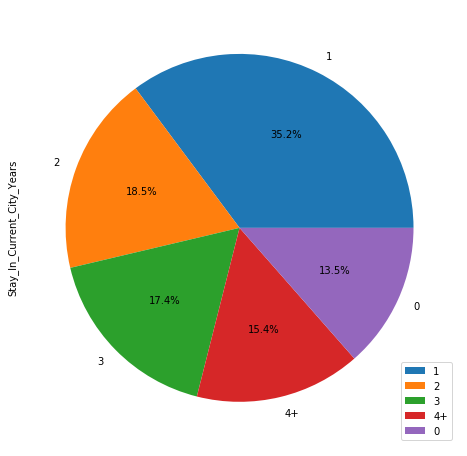

In [150]:
plot_pie('Stay_In_Current_City_Years')

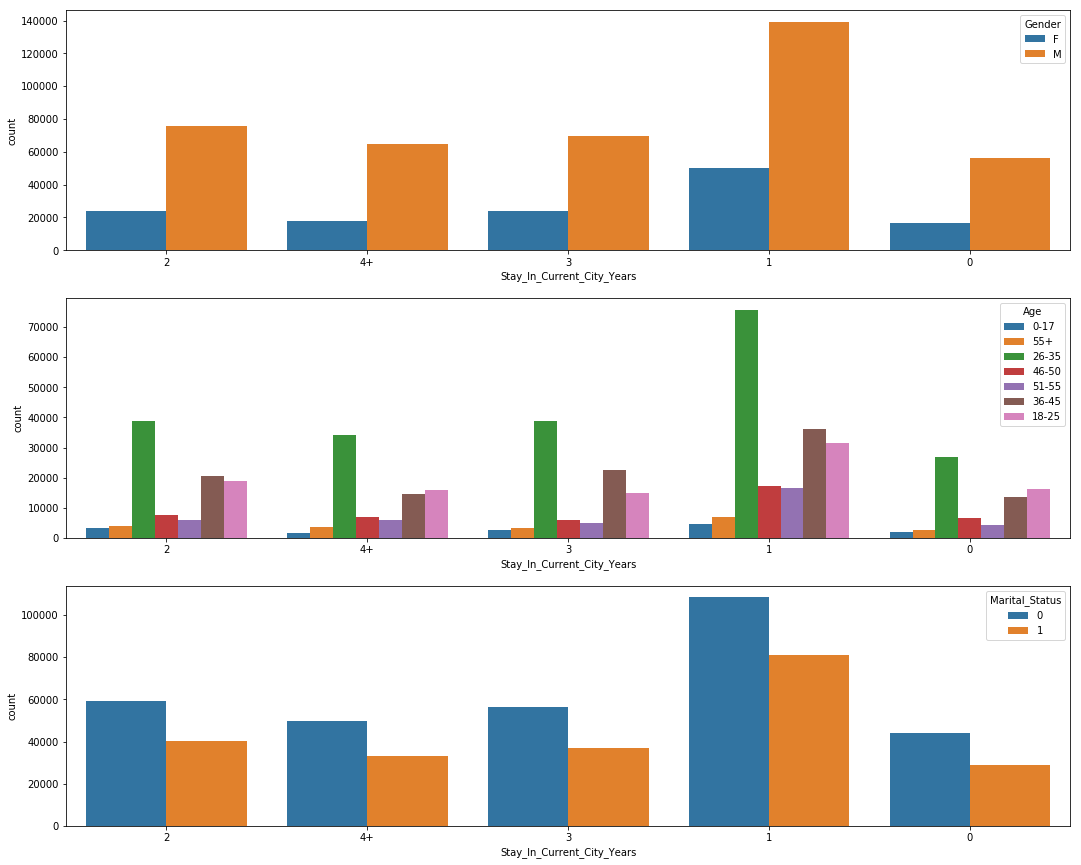

In [189]:
fig1, ax1 = plt.subplots(3, 1, figsize=(18,15))
sns.countplot(raw_df['Stay_In_Current_City_Years'],hue=raw_df['Gender'], ax = ax1[0])
sns.countplot(raw_df['Stay_In_Current_City_Years'],hue=raw_df['Age'], ax = ax1[1])
sns.countplot(raw_df['Stay_In_Current_City_Years'],hue=raw_df['Marital_Status'], ax = ax1[2])

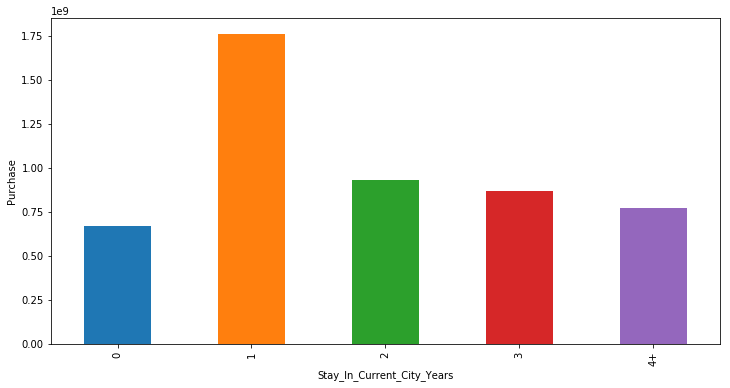

In [159]:
plot('Stay_In_Current_City_Years','Purchase','bar')

### Marital Status

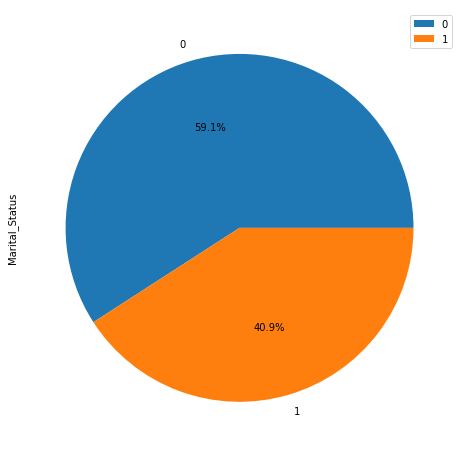

In [149]:
plot_pie('Marital_Status')

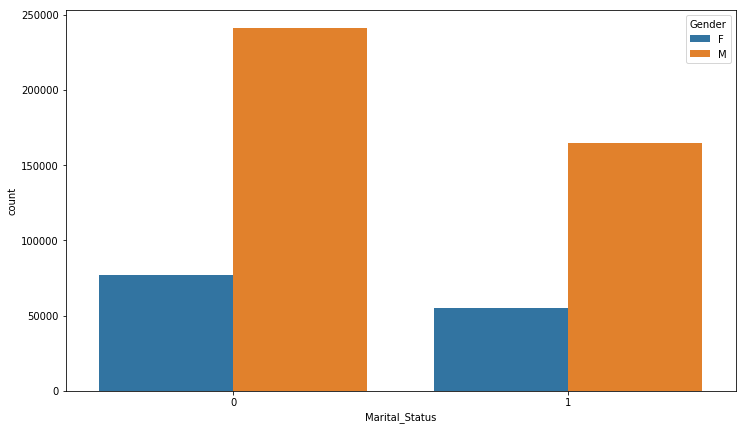

In [169]:
fig1, ax1 = plt.subplots(figsize=(12,7))
sns.countplot(raw_df['Marital_Status'],hue=raw_df['Gender'])

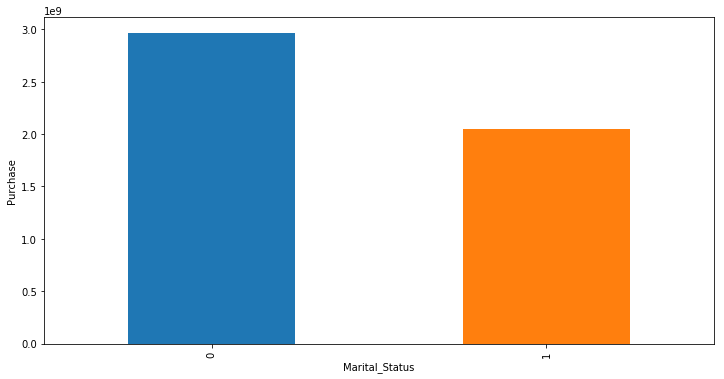

In [167]:
plot('Marital_Status','Purchase','bar')

In [36]:
top_k = 3

top = raw_df.groupby('Product_ID')['Purchase'].sum().nlargest(top_k)
topdf = pd.DataFrame({'Product_ID': top.index, 'Purchase': top.values})
topdf = raw_df.loc[raw_df['Product_ID'].isin(topdf['Product_ID'].values)]

In [37]:
topdf['Product_ID'].unique()

array(['P00255842', 'P00110742', 'P00025442'], dtype=object)

In [38]:
# splits datasets based on demographics specified
cats = ["Product_ID"]
temp = [topdf]

first = True
for split in cats:
    other_temp = []
    for other in temp:
        other_temp.append([other[other[split] == x] for x in other[split].unique()])
    if first:
        temp = other_temp[0]
        first = False
    else:
        temp = []
        for other in other_temp:
            for some_other in other:
                if not some_other.empty:
                    temp.append(some_other)

custom_clusters = sorted(temp, key=len)

Product ID P00255842


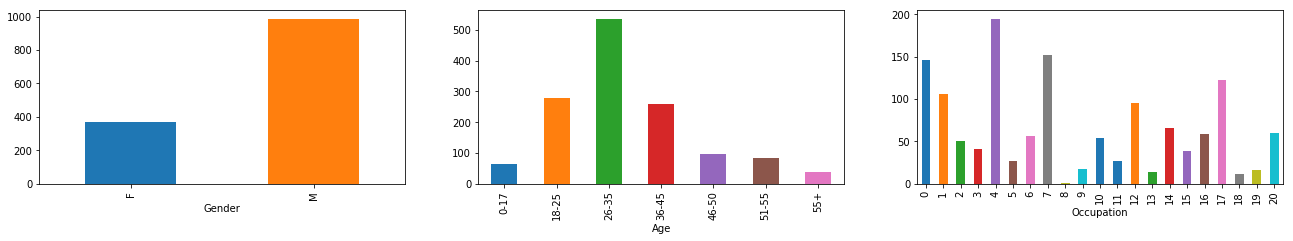

Product ID P00025442


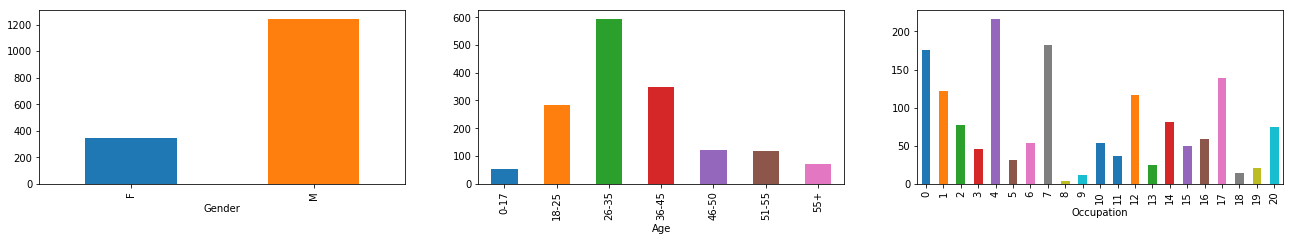

Product ID P00110742


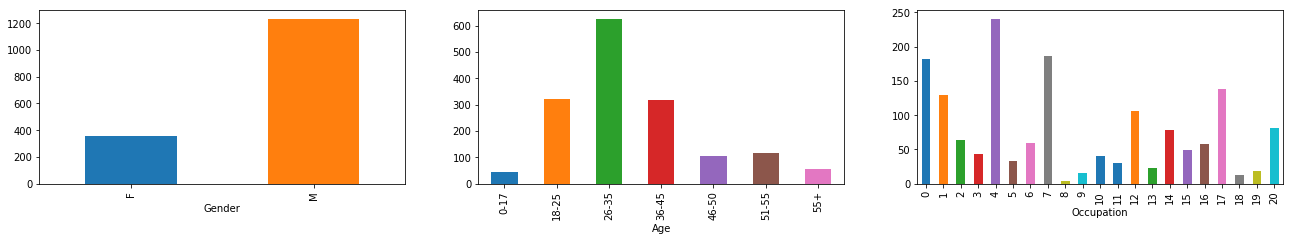

Product ID P00255842


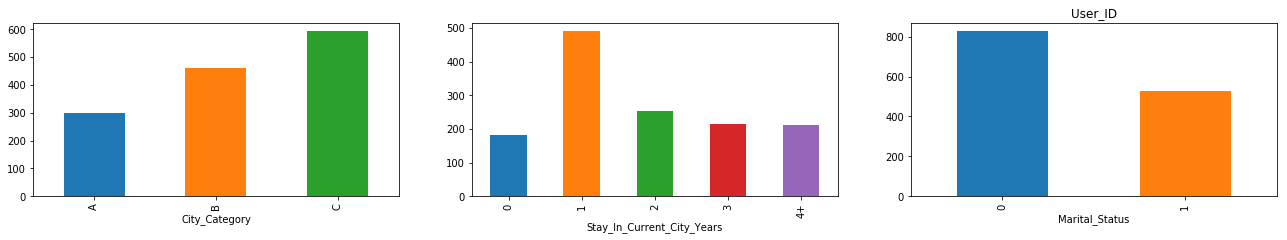

Product ID P00025442


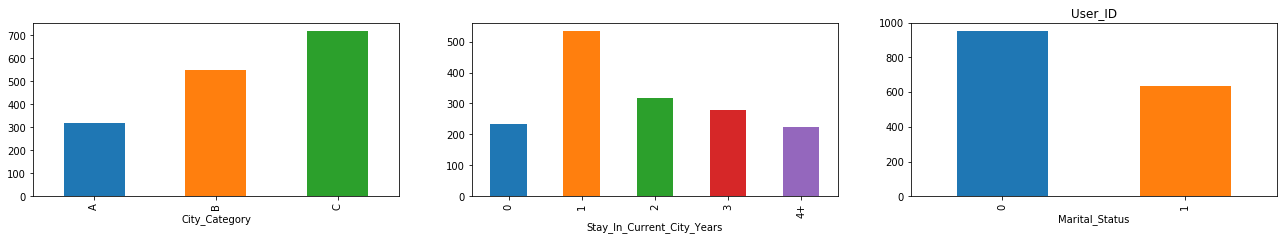

Product ID P00110742


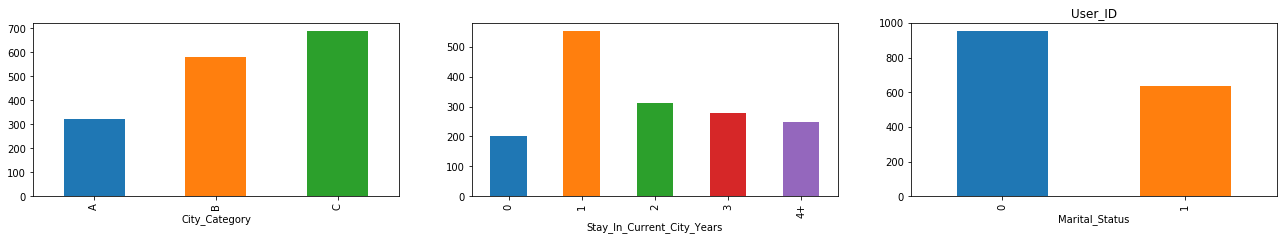

In [49]:
for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Product ID %s' % temp.iloc[0]['Product_ID'])
    temp['User_ID'].groupby(temp['Gender']).nunique().plot(kind='bar',ax=axes[0])
    temp['User_ID'].groupby(temp['Age']).nunique().plot(kind='bar',ax=axes[1])
    temp['User_ID'].groupby(temp['Occupation']).nunique().plot(kind='bar',ax=axes[2])
    plt.show()
    
for temp in custom_clusters:
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(18, 3))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    print('Product ID %s' % temp.iloc[0]['Product_ID'])
    temp['User_ID'].groupby(temp['City_Category']).nunique().plot(kind='bar',ax=axes[0])
    temp['User_ID'].groupby(temp['Stay_In_Current_City_Years']).nunique().plot(kind='bar',ax=axes[1])
    temp['User_ID'].groupby(temp['Marital_Status']).nunique().plot(subplots=True,kind='bar',ax=axes[2])
    plt.show()